In [29]:
import pandas as pd
import numpy as np
from time import process_time
import ast
import re
import regex
import csv
from string import punctuation
from collections import OrderedDict 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
def read_data(path):
    return pd.read_csv(path)

In [3]:
def preprocess_data(text):
    text = " ".join([word for word in text.split() if word not in punctuation])
    return text.strip()

In [4]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [5]:
training_data['text'] = training_data.text.apply(lambda x: preprocess_data(x))
training_data

,text,label
0,प्रा प्रताप हरिदास होय मला वाटते की हा एक महत्...,com_tech
1,तर विशिष्ट गोष्टींद्वारे ठराविक कायद्यांद्वारे...,bioche
2,म्हणून डेटा कुठे स्थित आहे जेथे विस्तार इत्याद...,cse
3,तर आपला अर्धा चिन्ह 9 वाजता असेल,phy
4,म्हणून मी असे म्हणालो की जर शेकडो हजारो किंवा ...,phy
...,...,...
41992,जरी आपण डेटा कूटबद्ध केला तरीही हा मुख्य व्यवस...,cse
41993,ते म्हणतात ज्याला पाहण्यासाठी डोळे ऎकण्यासाठी ...,com_tech
41994,प्रथम क्रोनोलॉजिकल क्रॉनोलॉजी म्हणजे आपल्याला ...,com_tech
41995,त्या थोड्या तपशीलावर येईल जेणेकरून संपूर्ण गोष...,bioche


In [6]:
x_train = training_data.text.values.tolist()
y_train = training_data.label.values.tolist()

In [7]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [8]:
val_data['text'] = val_data.text.apply(lambda x: preprocess_data(x))
val_data

,text,label
0,1 ची ओळ,cse
1,तर ही एक टॉवर आहे जी टॉवरवर निश्चित केली जाते ...,phy
2,तर थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी प...,cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शकतात,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,नंतर वृद्धत्व व्हॉट मोठ्या प्रमाणात फ्रॉन 12 र...,bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,तर आपण ELF शीर्षलेखासह प्रारंभ करू,cse
3778,तर त्या क्रॉस्टची जाडी आहे,phy


In [9]:
x_val = val_data.text.values.tolist()
y_val = val_data.label.values.tolist()

In [10]:
def custom_analyzer(text):
    # extract words of at least 1 letters
    words = regex.findall(r'\w{1,}', text)
    for w in words:
        yield w

        
def bow_vectorize(x_train, x_val):
        bow_vectorizer = CountVectorizer(analyzer=custom_analyzer)
        bow_vectorizer.fit(x_train)
        bow_x_train = bow_vectorizer.transform(x_train)
        bow_x_val = bow_vectorizer.transform(x_val)
        return bow_vectorizer, bow_x_train, bow_x_val

In [11]:
bow_vectorizer, bow_x_train, bow_x_val = bow_vectorize(x_train, x_val)
print(bow_x_train.shape)
print(bow_x_val.shape)

(41997, 52502)
(3780, 52502)


In [12]:
def get_embedding_dict(embedding_path, vocab):
    embedding_dict = dict()
    vocab_words = set(vocab.keys())
    embedding_file = open(embedding_path, 'r')
    for row in embedding_file:
        row = row.split()
        word = row[0].strip()
        if word in vocab_words:
            wv = np.asarray(row[1:], dtype='float32')
            if len(wv) == 300:
                embedding_dict[word] = wv
    return embedding_dict

In [14]:
embedding_path_ft = "/home/eastwind/word-embeddings/fasttext/cc.mr.300.vec"
embedding_dict_ft = get_embedding_dict(embedding_path_ft, bow_vectorizer.vocabulary_)
print(len(embedding_dict_ft))

33286


In [15]:
embedding_path_indic = "/home/eastwind/word-embeddings/fasttext/indicnlp.ft.mr.300.vec"
embedding_dict_indic = get_embedding_dict(embedding_path_indic, bow_vectorizer.vocabulary_)
print(len(embedding_dict_indic))

29724


In [16]:
embedding_path_ds_bow = "/home/eastwind/word-embeddings/fasttext/TechDofication.ft.cbow.mr.300.vec"
embedding_dict_ds_bow = get_embedding_dict(embedding_path_ds_bow, bow_vectorizer.vocabulary_)
print(len(embedding_dict_ds_bow))

51477


In [17]:
embedding_path_ds_skipgram = "/home/eastwind/word-embeddings/fasttext/TechDofication.ft.skipgram.mr.300.vec"
embedding_dict_ds_skipgram = get_embedding_dict(embedding_path_ds_skipgram, bow_vectorizer.vocabulary_)
print(len(embedding_dict_ds_skipgram))

51477


In [86]:
ft_words = [x for x in embedding_dict_ft.keys()]
indic_words = [x for x in embedding_dict_indic.keys()]
ds_bow_words = [x for x in embedding_dict_ds_bow.keys()]
ds_skipgram_words = [x for x in embedding_dict_ds_skipgram.keys()]
word_list = bow_vectorizer.get_feature_names()

In [91]:
intersect = set(ft_words) & set(indic_words) & set(ds_bow_words) & set(ds_skipgram_words) & set(word_list)
len(intersect)

28372

51477

In [94]:
diff = set(word_list) - set(ds_skipgram_words)
diff

{'Ion',
 'Research',
 '750',
 '17',
 '640',
 'Joules',
 '49',
 'RT',
 'x86',
 'Iaas',
 'पी1',
 '512',
 'System',
 '160',
 'Electrolyte',
 'E210',
 'LINUX',
 't15',
 'HTST',
 '0000',
 'metals',
 '178',
 '18',
 '1950',
 'TID',
 'Arrow',
 'X2',
 '430',
 '2003',
 'fins',
 'TLB',
 'alternates',
 'Cowards',
 '036',
 '76',
 '3600',
 'w4',
 'RESTFUL',
 'days',
 '77',
 '1971',
 'LaTeX',
 '1985',
 'एमएन2ओ3',
 '34',
 'Twitter',
 'v9',
 'L',
 'MapReduceम्हणतात',
 'ISSN',
 'HOMO',
 '115',
 'SIZE',
 '38',
 'Pc',
 'Word',
 '1965',
 '3000',
 'Thangaraj',
 'Now',
 '256',
 '2014',
 'PIC',
 'B',
 'Posture',
 'RAM',
 'व्हॅल्यूवर0',
 'B1',
 '98',
 'Ghosh',
 '100',
 'VMM',
 '1988',
 'VGA',
 'Q10',
 'Nirnay',
 '66',
 '005',
 'WATNA',
 'iCOMOT',
 '108',
 'equals',
 'Lithium',
 'SOAP',
 '347',
 '270',
 'logF1logF2',
 'r1',
 '65',
 'MAU',
 'Descartes',
 'Get',
 'टीसीए',
 '44',
 'w1',
 '140',
 '2000x0',
 '25',
 '00',
 'Act',
 'RIS',
 'DOM',
 '134',
 'Pआहे',
 'Ai',
 'CONFERexecute',
 '1990',
 '157',
 '1880',
 '37

In [61]:
intersect

{'योगदानाबद्दल',
 'उदाहरणामध्ये',
 'दबावाचा',
 'आरएफआयडी',
 'आतापेक्षा',
 'कॅपॅसिटर',
 'जाणाऱ्या',
 'बनवलेला',
 'तक्रारीच्या',
 'काढावा',
 'सोल्युशन्स',
 'होण्यासही',
 'मानणार',
 'उद्देश्य',
 'गतिविधी',
 'मैत्रीचा',
 'पासवर्डची',
 'मल्टिमिडीया',
 'लवकरात',
 'पदे',
 'आपल्यालाच',
 'व्यवस्थापित',
 'स्वास्थ्य',
 'किंमतीचा',
 'जाई',
 'स्थानांतरित',
 'दुधाला',
 'पोचते',
 'तापत',
 'सहाय्याने',
 'फ्रीजर',
 'फाईलमध्ये',
 'मुख्यतः',
 'जॉबसाठी',
 'मूल्याला',
 'मील',
 'सुसंगतता',
 'सभेस',
 'साठवायचा',
 'जा',
 'विक्रीमध्ये',
 'मोजू',
 'पॉलिसीचे',
 'हाताळते',
 'अग्रक्रमाने',
 'संबंधांवर',
 'कपात',
 'टेनिस',
 'उपासना',
 'मिडियावर',
 'हॉटेलमध्ये',
 'बातमीकडे',
 'संदर्भात',
 'अडचणींमध्ये',
 'संवेदनशीलता',
 'याभोवती',
 'असंबद्ध',
 'मुद्यांच्या',
 'राहण्याचा',
 'येऊ',
 'संस्थांकडे',
 'डॉक्टरकडे',
 'सूर्यापासून',
 'भागांमधील',
 'बोलण्याची',
 'समुदायाकडून',
 'साधेपणाची',
 'उंचीपर्यंत',
 'जनरेट',
 'किंमतीवर',
 'अश्या',
 'ऐकलेले',
 'पध्दतीने',
 'मुद्यांचा',
 'तुकड्यात',
 'ज्यावरून',
 'ठेवलेली',
 'तितकी',
 'ओ

In [80]:
def visualize_embeddings(words, embeddings):
        vectors = []
    
        # convert both lists into numpy vectors for reduction
        embeddings = np.asarray(embeddings)
        words = np.asarray(words)

        vectors = np.asarray(vectors)
        tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
        vectors = tsne_model.fit_transform(embeddings)
        print(vectors.shape)

        x = []
        y = []
        for value in vectors:
            x.append(value[0])
            y.append(value[1])

        plt.figure() 
        
        for i in range(len(x)):
            plt.scatter(x[i],y[i])
            plt.annotate(words[i],
                         xy=(x[i], y[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
       
        plt.show()

In [70]:
words = []
embeddings = []

word = "देशांचा"
embeddings.append(embedding_dict_ft[word])
words.append("fasttext")
embeddings.append(embedding_dict_indic[word])
words.append("indic-fasttext")
embeddings.append(embedding_dict_ds_bow[word])
words.append("DS-fasttext-bow")
embeddings.append(embedding_dict_ds_skipgram[word])
words.append("DS-fasttext-skipgram")

In [72]:
for word in intersect:
    embeddings.append(embedding_dict_ft[word])
    words.append("fasttext")
    embeddings.append(embedding_dict_indic[word])
    words.append("indic-fasttext")
    embeddings.append(embedding_dict_ds_bow[word])
    words.append("DS-fasttext-bow")
    embeddings.append(embedding_dict_ds_skipgram[word])
    words.append("DS-fasttext-skipgram")

(40, 2)


<IPython.core.display.Javascript object>


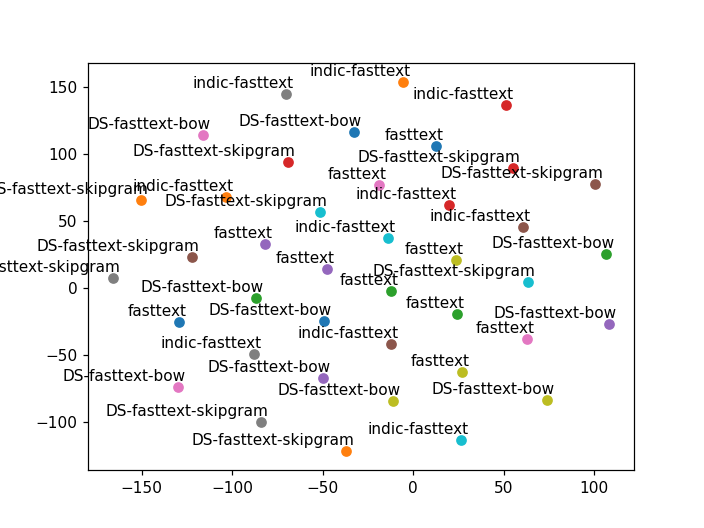

In [82]:
visualize_embeddings(words[:40], embeddings[:40])

In [138]:
def analyze_vocab(vocab_words):
    numbers = []
    english_words = []
    marathi_words = []
    for word in vocab_words:
        if any(map(str.isdigit, word)):
        #if re.match('\d+', word):
            numbers.append(word)
        elif re.match('[a-zA-Z]+', word):
            english_words.append(word)
        else:
            marathi_words.append(word)
    return numbers, english_words, marathi_words

In [96]:
vocab_words = bow_vectorizer.get_feature_names()

In [139]:
print("Total Vocabulary: ", len(vocab_words))
numbers, english_words, marathi_words = analyze_vocab(vocab_words)
print(len(numbers))
print(len(english_words))
print(len(marathi_words))

Total Vocabulary:  52502
597
931
50974


In [140]:
for words in numbers:
    print(words)

0
00
000
0000
0005
001
002
005
01
011
016
02
021
025
025xC
025xM
029
03
033
036
038
04
043
045
05
052
055
056
06
068
07
08
0800
088
09
0s
0x0
0x00124345
0x12345
0x1f0
0x1f2
0x1f7
0x7c00
0x8
0x80
0x80000000
0x80124345
0xFE
0xf000
0xfff0
1
10
100
1000
10000
100000
1000000
1000IU
100ओळ
101
1010
102
1024
103
1030
105
108
10ºC
11
110
1100
11000
111
1125
114
115
11ट
12
120
1200
121
122
1220
124
125
127
128
13
130
1300
133
134
135
1377
138
139
14
140
1400
142
1424
1450
146
149
15
150
1500
15000
150000
151
1545
157
159
1590
16
160
1670
168
17
170
1700
172
175
1754
176
178
18
180
1800
18000
1823
1839
185
1859
1880
19
1900
1901
1917
1925
1930
1937
1940
1946
1947
1948
1950
1954
1955
1960
1965
1967
1970
1971
1973
1977
1979
1980
1981
1983
1985
1988
199
1990
1992
1995
1998
1999
1f0
1f7
1z
1अध
1ट
1प्रोसेसरच्या
2
20
200
2000
20000
2000x0
2001
2002
2003
2004
2005
2006
2007
2008
2009
201
2010
2011
2012
2013
2014
2015
2016
2017
2020
2022
2030
207
21
212
2170
218
22
220
22000
225
2260
23
230
2308
232
233


In [129]:
diff = set(marathi_words) - set(ds_skipgram_words)
len(diff)

4

In [130]:
diff

{'कृत्रिमपणा', 'टीसीए', 'देशपांडे', 'पोस्टइट'}

In [126]:
for word in diff:
    if any(map(str.isdigit, word)):
        print(word)

व्हॅल्यूवर0
एस1
व्ही1
पी2
सीएच3
पी1
सीओ2
सी3
दाब2
ए1
द825
सी2
०8
व्ही2
सी4
आर1
०4
सीओओ2
उतरलात0
वेग1
सी6
सी16
अधिक1
ओ2
१55
एमएन2ओ3
सी10
एस0
सीएच2
एमएनओ2
एच2
१5


In [119]:
diff

{'अधिक1',
 'आर1',
 'उतरलात0',
 'ए1',
 'एच2',
 'एमएन2ओ3',
 'एमएनओ2',
 'एस0',
 'एस1',
 'ओ2',
 'कृत्रिमपणा',
 'टीसीए',
 'द825',
 'दाब2',
 'देशपांडे',
 'पी1',
 'पी2',
 'पोस्टइट',
 'वेग1',
 'व्ही1',
 'व्ही2',
 'व्हॅल्यूवर0',
 'सी10',
 'सी16',
 'सी2',
 'सी3',
 'सी4',
 'सी6',
 'सीएच2',
 'सीएच3',
 'सीओ2',
 'सीओओ2',
 '०4',
 '०8',
 '१5',
 '१55'}

In [50]:
marathi_words[:30]

['δδ',
 'δδt',
 'δवाढतो',
 'ε',
 'εi',
 'ηi',
 'ρ',
 'σ',
 'σD',
 'σμ',
 'ω',
 'अ',
 'अँकर',
 'अँगल',
 'अँग्स्ट्रॉम्स',
 'अँग्स्ट्रॉम्सपेक्षा',
 'अँट',
 'अँटनीने',
 'अँटनीला',
 'अँटिबायोटिक्स',
 'अँटिमनी',
 'अँटिरूम',
 'अँटी',
 'अँटीऑक्सिडंट',
 'अँटीऑक्सिडंट्स',
 'अँटीऑक्सिडेंट',
 'अँटीजन',
 'अँटीजेनशी',
 'अँटीबायोटिक',
 'अँटीबायोसिस']

In [75]:
for text, label in list(zip(x_train, y_train)):
    if "εi" in text:
        print(label)
        #print("text: {}, label: {}\n\n".format(text, label))

com_tech
com_tech
com_tech
com_tech
com_tech
